# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from dirrac.classifier.logistic import logistic_classifier, logistic_visualize
from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.gen_counterfactual import DRRA
from ar.gen_counterfactual import LinearAR
from wachter.gen_counterfactual import Wachter
from roar.gen_counterfactual import ROAR
from mace.loadModel import loadModelForDataset
from utils import pad_ones, cal_validity

[ENV WARNING] deactivate virtualenv to allow for testing Actionable Recourse


In [2]:
if not os.path.exists('result/figure3/'):
    os.makedirs('result/figure3/')

# Synthesize data and train original classifier

In [4]:
# Synthesize data 
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000
p = [0.3, 0.4, 0.3]

sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.3, 0.4, 0.3], [0.1, 0.1])

In [5]:
# Train 101 logistic classifiers - the first classifier is on original data, other
all_coef = np.zeros((101, 3))
for i in range(101):
    coef = logistic_classifier(pad_ones(features[i]), labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta
mean_shift = all_coef[1:31]
cov_shift = all_coef[31:71]
both_shift = all_coef[71:101]

theta = np.zeros((3, 3))
sigma = np.zeros((3, 3, 3))

theta[0], sigma[0] = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta[1], sigma[1] = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)
theta[2], sigma[2] = np.mean(both_shift, axis=0), np.cov(both_shift.T)

# Save to csv

In [6]:
df = pd.DataFrame(columns=['label', 'x0', 'x1'])
df['label'] = labels[0]
df['x0'] = features[0][:, 0]
df['x1'] = features[0][:, 1]
df.to_csv('mace/_data_main/processed_data/synthetic_data.csv', index=False)

In [7]:
df

,label,x0,x1
0,0.0,-2.776021,-2.255409
1,0.0,-3.334269,-1.610828
2,0.0,-5.296095,-1.858795
3,0.0,-2.944552,-3.082760
4,0.0,-3.651688,-3.016022
...,...,...,...
995,1.0,1.891151,4.456270
996,1.0,1.099763,4.243181
997,1.0,2.240315,3.742204
998,1.0,3.128713,2.557857


In [8]:
# Train the original classifier and get the instances that are classified as negative class
model_trained, X_train, y_train, X_test, y_test = loadModelForDataset('lr', 'synthetic')
X_recourse = X_test[model_trained.predict(X_test) == 0]

# Initialization

In [9]:
# DDRA 
delta = 0.1
k = 3
dim = 3
rho = np.array([0, 0, 0])
lmbda = 0.7
zeta = 1

drra_module = DRRA(delta, k, dim, p, theta, sigma, rho, lmbda, zeta, dist_type='l1', padding=True)
ar_module = LinearAR(X_train, model_trained.coef_, model_trained.intercept_)
wachter_module = Wachter(X_train, model_trained, decision_threshold=0.6, linear=True)
roar_module = ROAR(X_train, model_trained.coef_.squeeze(), model_trained.intercept_, max_iter=30)

# Generate counterfactual

In [10]:
print("Generate counterfactual for DiRRAc")
counterfactual_drra_nm = drra_module.fit_data(pad_ones(X_recourse), model='nm')
print("Generate counterfactual for Gaussian DiRRAc")
counterfactual_drra_gm = drra_module.fit_data(pad_ones(X_recourse), model='gm')
print("Generate counterfactual for AR")
counterfactual_ar = ar_module.fit_data(X_recourse)
print("Generate counterfactual for Wachter")
counterfactual_wachter = wachter_module.fit_data(X_recourse)
print("Generate counterfactual for ROAR")
counterfactual_roar = roar_module.fit_data(X_recourse)
# print("Generate counterfactual for MACE")
# counterfactual_mace = runExperiments(['synthetic'], ['lr'], ['one_norm'], ['MACE_eps_1e-5'], 0, len(X_recourse), 'neg_only', '0')

Generate counterfactual for DiRRAc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


Generate counterfactual for Gaussian DiRRAc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Generate counterfactual for AR


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.17it/s]


Generate counterfactual for Wachter


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


Generate counterfactual for ROAR


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.10it/s]


In [11]:
# Define shift params
alpha_l = [0.1 * i for i in range(11)]
beta_l = [0.1 * i for i in range(11)]

def run_experiments(shift_type='mean'):
    """ Run experiments for 3 types of data distribution shifts """
    # Init
    validity_drra_nm, std_drra_nm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_drra_gm, std_drra_gm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_ar, std_ar = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_wachter, std_wachter = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_roar, std_roar = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))

    for i in range(1, len(alpha_l)):      
        
        mean_shift = mean_0 + [alpha_l[i], 0] if shift_type in ['mean', 'both'] else mean_0
        cov_shift = cov_0 * (1 + beta_l[i]) if shift_type in ['cov', 'both'] else cov_0
        
        iter_drra_nm = np.zeros(100)
        iter_drra_gm = np.zeros(100)
        iter_ar = np.zeros(100)
        iter_wachter = np.zeros(100)
        iter_roar = np.zeros(100)

        features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
        for j in range(100):
            features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
            clf_shift, coef_shift = logistic_classifier(features, labels)

            iter_drra_nm[j] = cal_validity(clf_shift.predict(counterfactual_drra_nm[:, :-1]))
            iter_drra_gm[j] = cal_validity(clf_shift.predict(counterfactual_drra_gm[:, :-1]))
            iter_ar[j] = cal_validity(clf_shift.predict(counterfactual_ar))
            iter_wachter[j] = cal_validity(clf_shift.predict(counterfactual_wachter))
            iter_roar[j] = cal_validity(clf_shift.predict(counterfactual_roar))
        
        validity_drra_nm[i], std_drra_nm[i] = np.mean(iter_drra_nm), np.std(iter_drra_nm)
        validity_drra_gm[i], std_drra_gm[i] = np.mean(iter_drra_gm), np.std(iter_drra_gm)
        validity_ar[i], std_ar[i] = np.mean(iter_ar), np.std(iter_ar)
        validity_wachter[i], std_wachter[i] = np.mean(iter_wachter), np.std(iter_wachter)
        validity_roar[i], std_roar[i] = np.mean(iter_roar), np.std(iter_roar)

    # Validity for original data
    validity_drra_nm[0] = cal_validity(model_trained.predict(counterfactual_drra_nm[:, :-1]))
    validity_drra_gm[0] = cal_validity(model_trained.predict(counterfactual_drra_gm[:, :-1]))
    validity_ar[0] = cal_validity(model_trained.predict(counterfactual_ar))
    validity_wachter[0] = cal_validity(model_trained.predict(counterfactual_wachter))
    validity_roar[0] = cal_validity(model_trained.predict(counterfactual_roar))

    return validity_drra_nm, validity_drra_gm, validity_ar, validity_wachter, validity_roar, std_drra_nm, std_drra_gm, std_ar, std_wachter, std_roar

# Data distribution shift plot

In [26]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE - 2)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

# Mean shift

In [27]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_wachter, validity_roar, std_drra_nm, std_drra_gm, std_ar, std_wachter, std_roar = run_experiments(shift_type='mean')

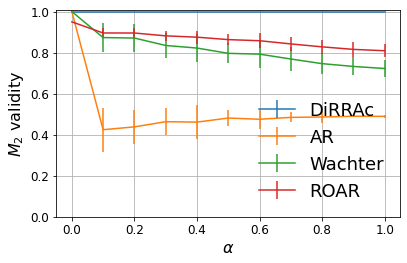

In [28]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\alpha$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/mean_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()# Define shift params

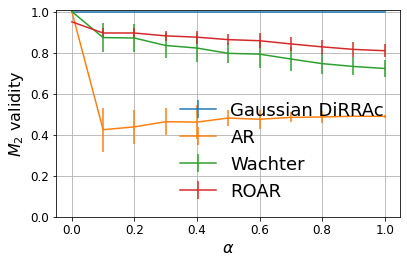

In [29]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\alpha$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/mean_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Covariance shift

In [30]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_wachter, validity_roar, std_drra_nm, std_drra_gm, std_ar, std_wachter, std_roar = run_experiments(shift_type='cov')

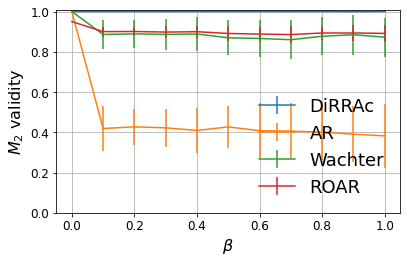

In [31]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/covariance_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

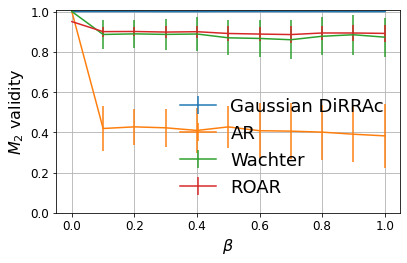

In [32]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/covariance_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Mean and Covariance shift

In [33]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_wachter, validity_roar, std_drra_nm, std_drra_gm, std_ar, std_wachter, std_roar = run_experiments(shift_type='both')

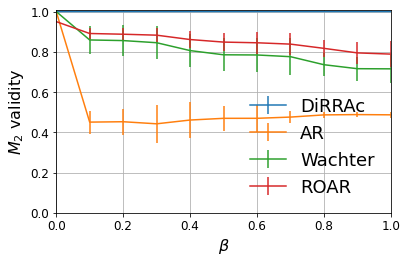

In [34]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
ax.sdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZcAAAEHCAYAAABiAAtOAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAABMQUlEQVR4nO3deXhTVfrA8e9J0jWllAItmyxlU0RBKLvQFlldRkFUZFjVwZFR3HFEEURFUUfHcRlFoICCOq7oD0VBqQIqAsoqi8ouFChQIF1ok5zfHzcNTZvSpk0a2r6f58mT3HPPvXlP0+btuefce5XWGiGEEMKfTMEOQAghRPUjyUUIIYTfSXIRQgjhd5JchBBC+J0kFyGEEH4nyUUIIYTfSXIRQgjhd0FPLkqpO5VS65RSZ5RS80qpe69SKl0pdUopNVcpFVZJYQohhPBB0JMLcBB4Eph7rkpKqYHAP4ErgGZAAvB4wKMTQgjhM3W+nKGvlHoSaKK1HlvC+kXAHq31ZNfyFcBCrXWDc+23Xr16unnz5uWK6WTWCZx5TsKsMeXavirLyckhIiICAFVSpRJWeC9W3pdK3HnwZGdnExkZ6VmoPZ6KryhTackrzo+/wjJ+7kWVoWJlfszl+VnmZOcQERnhURaI3+Py/hzK/fuhvb70kJebTXStqHLtfv369Rla6/re1lnKtcfguBhYXGh5IxCvlKqrtT5W0kbNmzdn3bp1Pr9Zdu4p+i/qgdkRxoE/b8eZ28T3iKu47GAHEESngx1AENXUzz0r2AEESVyE4qepV5ZrW6XU3pLWVaXkEgWcLLRc8LoW4JFclFLjgfEA8fHxpKWllesN/3m6Hv+OyqBWi//SJeRq2lv6oNT5cCQx8HJzcgmPCKdox7bofz+6hP/ovZXrIi90KeXBcuZMLuFh4e5/Mwv+2yz6X2rR/0Ld9ZRv5ZSwPhhK+twLnOuz0WX4L7ksdbwp6Ufj68+spOq5ubmEh4d7/r6W9Ltd5EVpv8fF/zY8S/Q54lIlNLDY72SRBeW92Gudeubccn9HnktVSi42ILrQcsHrYv9kaq1nAbMAEhMTdXJycvneMXIkfZZOYkrXoaw4vJjQuOM8efmTxIbHlm9/VUhaWhrl/rlVcdL25GCHUelqarshcG2vSv+GbwU6FFruABw+1yGxCktIobbTyUuxPZjcbTJrDq1h2KfD+OnQTwF7SyGEqA6CnlyUUhalVDhgBsxKqXCllLce1QLgVqVUO6VUDPAoMC+gwdVtSW5YfdTuNG6+8GYWXbUIa4iV2766jZd/eRm70x7QtxdCVG/jlo5j3NJxwQ4jIIKeXDCSRA7GNOORrtePKqWaKqVsSqmmAFrrpcCzwApgH7AXmBrQyJTiRJ0OsPs7cDpoG9uW965+j2tbXcusTbO45ctbOGQ7FNAQhBCiKgp6ctFaT9NaqyKPaVrrfVrrKK31vkJ1X9Bax2uto7XW47TWZwId34k6HSD3JBzcAEBkSCRP9HqCZ3o/w84TOxn22TC+3vt1oMMQlWTc0nG8lP5SsMMQlUg+88AIenI5352oc6nxYtcKj/KrEq7if1f/jya1mnBP2j08+eOTnHEEPNcJIYTfBDKxSnIpRX5oDDS4BHalFVvXNLopbw9+mzHtxvDejvcYsWQEuzJ3VXqM1U11Pg4tRE0hyeUccnfshPx8SEiG/Wsgr/hpViHmEB7o8gCvXfEaR7OPMnzJcD7+7eNic9l9FcwvWDlMEBzBTqrB/NyD3Xbhf5JcSqAdDvbdeiv1H5zEnx/s4dRuE87taSXW792kNx/85QMurXcpj33/GA+tfAhbnq3yAhZCiPOIJJdzaPT0DHITE8navIs/v49l54hJ7J/wDzI//gRHZmax+nGRcbzR/w0mXjaRr/Z8xQ2f3cCWjC2VH7gQQgSZJJcSKLOZqN69OT3yr7RetZJmf21MTPsQcrdt49DDD7Oz1+Xsu+UWTrzzDvlHjri3M5vM/O3Sv5E6KBWHdjDq81HM2zIPp3YGsTVCCFG5JLmUgTKbiUweTIMLd9Pq03do/v771L31VvIPHiL98en8npTMnptHcGxuKnn79wNwWdxlvH/N+yRfkMy/1v+LCV9P4FhO4C4mIIQQ5xNJLmWVkAKA2v0dEZe0J+6+e0n44nMS/u8z6k+8C+eZXI48+yx/9B/AriFDOfraa4TvO8K/kv7Fo90eZe2htQz7bBg/HvoxyA0RQpwvhr+8leEvbw3q+9+WWuKFjSukKl24MrgadoDwGGNK8qU3AMYVS8NatSKsVSvq3XEHeQcOcHrZck4vW0bGy6+Q8Z+XCW3enJT+/enQ7XEeOjqL8V+N57ZLbuOOjncQYgoJapPOV+4/tkHBeW+73Q7Dg/PeQFDaHWw19TOvziS5lJXJDAlJxsmUWnu91ndokybUHTeWuuPGkn/kCLZvvuH0V8s4lpoKb9p5Lj6ebZc0Z+G+Waw9uIZnkp+lcVRjr28nf2yissnnLvxJkosvEpLh18Vw7Heo1/qcVUPi4qgzfDh1hg/HkZnJ6bQ0Ti9bTtuVq3j8jINTH//C/7W9knbX30Kvv9yBKTS0ctoghBCVQJKLL1zjLvyxotTkUpg5JoaY664j5rrrcGZlYVu5CssXi+mW9i1hv7zOlqfmENO3HzEDBhHV+3JMRW+xK4QQVYwkF1/EtoCYZsa4S7fx5dqFyWoletBAogcNJC8ni/cWPcLJr76ie9pXZC35AhUWhrX35USezicv3GzMPnM6QWvjrH8NoI1Dc1qjnc5iZUa563XRcu257LFfbbxPWLadEIeDrDU/oUIsKIvxwGw597LrWZmq1jwR7XSCw4F2OlHun5sQoiIkufiqZQps+QgcdjBX7McXGmFl1K3/ZvWg1Tz47cM02XWa2zM7Yl67hXpHcgH4o/8Af0Ttk3jX874xY8q3A5OpeMIp87KZeodyAM2+228HhxOcDrTjbAI457N2gsOJdjo8ns+1TWEXuJ63d7wMU60ozNYoTLVqYYqyYo6KwhRVC1NUFOZaUZisUUadKFcdq6u8YDkyssolWiH8RZKLrxKSYf08OPgzXNDVL7vs1bgX7w/5iIdXPswdh35k4FUD6PfMCqKyNe3vn2rcR7vggfGsTMXLULjWmQqVu8qUApPJo67HfpXJXfbTQ7fjcDjoPnMW2m5H2/PBbkfbHUWWC8pKWM53lTmMZwqWXWUey3Y7+swZtN2OxW6ccOo4mgFms9Ee17MKCUGFhxkTLMwmlE/PhfZlNoGp+PPO+a+iHU5aXT8C5+nTOLNsOE7bcNps5GUcw2EzXjttttJ7OEphslqLJKOiicqK2ZWYImz5aJMi68c17h5hab1FjwRtNvvl97Eq0lqj8/NxZmV5eWSffZ1dZF12NvUPZoNTs2fkyEqPO+7PbAD2jh5z9vfUYj77e2u2FPodNZ/93TWbPX+ni2xTsC9lMZ/9/fbYl7EceTqfHEtgeuqSXHzVIglQxqExPyUXgHoR9Xij/xvM3TKXV355hbV/cTJ4s4Xcy6Kwazt2ZwkPbSffme91nUM7PNfl273uK9+Z71FuG2bHicZ64DEsJgtmkxmzMhNiCsGszFhCLZjDzVhMFizKYtRRZsymImUms+t1RMl1lGvZdHb51389jlbQ7r5ROLUTh3bgcDpwaIexXPi1drjXF152aid2px2ndrrK84pvV2Qbh3aQMQRC8xSXJdlpFNWShtaGNIpqRENrQ2LDY42EjHEozZmdg9N2GqfNhuP0aZy2LJy200YCciUkh81VXpCoMjPJP3DAXa5zcty/A/Vdz/vGji3fL5FSRrIJCUGZzWeTT4gFZTlb5l52JSQVYiSoeody0Dg5cO+9xpeaqydpfMGZz762FHzJuV5bLN7LXc/Gl6LrdUGCLFIecsaB0mBbuQpndnYJSSLLc112Fo5CyQN72e4Mq0JCMEVGGonfasXk1DjB+FIOEu10QH4+zoIet8Ph6l07wF6ot+0udxr/wBXqhResw1n2q4HUAzLqBOaUCFXRq/ee7xITE/W6devKvX1aWhrJycmehW8kQUgk3PJFxYIrwYYjG5j4wWhOWH37bCwmCyGmEPcXt9eHctXxUl7w+sg3X4LTSaMB17iTlN1px+F0kK/zcTgdHuUedQqVlVSu8f/vnEmZjOSlzMZrU6HXrqTmsazMmEwmLMriLjMpEyd/3USOxYktLgpbvueFR8PN4TSwNqBRVCPjYW1Ew6iGNLIay/Uj6mM2+dZ7KPhv22GzsWrstSinpuvTr5/t/Tkcrh5g6b1Fbbef7TE6vPcgPZYL6rsep3b+CloT1aS58UVV8P4lvC56SDFgLBZXIojEbLViirSeTQxWq2eiKPrwWGdsr4rMzPzyqq7Y7Xau+vLnUkNxaie59lyy8rPItmeTnZ999rVrOTvfeJ2Vn+V+7VFWqN7prBM4zBAdXps6YXWICYsxHuExxnJ4jLusTvjZ9dGh0SX+rmmtPQ//niMhrRx3HXnaweDlv5Tro1FKrddaJ3pbJz2X8miZAt+/DGdsEBbl9913jOvIA0vDOByt6f2ft70mC3cvotB//MrLuTfl8eXMFcYf2/Sn/LK/ogp6FQU9r6LJKu2261BA0uxP3InhnElCmfzX9lcLvmh+4FTeKQ7ZDnHQdpCDWQeN167n7ce3czz3uMe2FmUh3hrv7u0UTUANrA0INXt+samQEMwxMZhjYsgPM74srN381yP2hftL9ovPy1Rfa3026dgd4Ch4bT/7pVZovbbnG+UedY3XP0+9B60UXf41u3iC8PM0fYfTwbHcYxzOOkx6djorW9s5FeJg80/PFEsMOfYcz4Rgzy7z+4SYQogMicRqsRIZEmk8LJHUDa+LNcQoO7z4Q8xOqDdkECfPnOTEmRMcyjrEr8d/JTM3kzxnntd9KxS1w2q7k07tsNruZFQ4SXkkpLDamJTnGKA91ITTHpjrHkpyKY+EZFj1IuxdDW0GBuQtwhyKpicUF8ZeGJD9n8u7d11MZmYmVwVo/yZlItQcWuyLtkB9m/EH0KRWkwBFUDbRodFEx0bTNrat1/U59hwOZR3ySDoFz2sOreFozlGPC5YqFPUi6rmTTcOohjS2NnYvn7Fowuz+SZKVQSllHIILqfhhlRyrsY/ITp0qtB+ndnIs5xjpWekczj7s9flo9lHsutAhtMtAOSHq90+JCIkwvvgtRjKIj4wnIiSCSEukOyEUvI6wRBQrK9gu0hJJiLn0n8uXT3wKwMCZjxZbp7Umx55D5plMTpw5QWZuJplnjMeJ3BPu15m5mRy0HeTXjF85ceYE+c58r+9lUiZqh9b26A1lJeZx6e7y/axLI8mlPC7oDpZwY9wlQMnl3bsuBiAwexf+EGGJIKF2Agm1E7yuz3fmczjrMIeyivd+th7bytf7vvb8IhgKYfnwxLuXnz10qSyEmEOKHdIsfGizpNfe1pW4X3MIWxs6MOU52XBkAxGWCCIsEYRbwt3Pwb5cUUHiKJY0XD2Qw1mHOZJ9xDNxAGHmMOIj44m3xpMYn0i8NZ4GkQ2MZ2sDfr11FKHZdq7+8vsgtcw7pZS7x9MoqlGZtilISIWTUcHrE2dOGL0jV2I6YDvA4QYOLjgSmIkgklzKIyQcmvYwTqYUfhfMxOrPXluIKYQmtZqU2ANzaicZORkctB3kUNYh0l6ZzOlwTeNrBp+diKHt5DvOvi6YgJHnzCPbnu0xYSPfmV9sckfBcpnGuXobT3O+GOV1tcVkIcJcPOkUTkSRlsiz68zF6xTdNtISSYQlgnyzJicEtmRs8SlxhJpCaWA1EkXn+M4eiSM+0kgeMWEx5zxsujdPYafq9BjPpXBCKunSUoUVHAoNBEku5ZWQDMunwul0qNUg2NGIKsikTMRFxhEXGUdHOmLaPhWAgU894vf3cjiLzBwslLTytfH83V0jyMVOx5mvkGvPJcee434ULOc6vJefyD3hsZzjyMHu9OFL63rX85Kb3UWhplB376JTfCcjibgSRlkThwgeSS7l1TLFSC670qCDXOlPnN/MJnOpM9l2nzBht5u4vPHlfnnPfGf+2aRUJFkVTVgbZz9PeL6i74MvuA9h1QmrUymJI9BjjDWVJJfyir8EIutKchF+E+xxNn9/yYaYQggJDaFWaK1S69bb/hIAyRck++ndq4Zgf+aBJMmlvEwm44TKP0q+BL8QQpzPAtlrk+RSEQnJsPUjOLoD4ip/yrAQ1UV1/g++ppKr6lVES9cl+HfJrDEhhChMkktFxDSF2ARj3EUIIYSbJJeKSkiBPavA4f2sWCGEqIkkuVRUQjLk2eBA+S+OKYQQ1U3Qk4tSKlYp9bFSKksptVcpNaKEemFKqdeVUoeVUseVUp8ppUo/BTXQWvQ27oVSjcZdUgelcneDu4MdhhCiCgt6cgFeBfIwboD4V+C/SqmLvdS7G+gBXAo0Ak4AL1dWkCWKqAONLvP7uEvqoFRSB6X6dZ9CCFFZgjoVWSllxbjwQ3uttQ1YpZT6FBgF/LNI9RbAl1rrw65t3wNeqMx4S5SQYlwlOfckhNcOdjRVniRVIaq+YPdc2gB2rfXOQmUbAW89lzlAL6VUI6VUJEYvJzB36/JVQjJoB+xZHexIRAXJIUEh/CPYJ1FGAaeKlJ0EvF0v4jdgP/An4AA2A3d626lSajwwHiA+Pp60tLRyB2iz2UrdXjnzudwUxqGVb/N7emS53+t8UpZ2V1fBantmZiZA0H7umZmZOByOGtf2mtrugvcPVNuDnVxsQHSRsmjgtJe6rwJhQF0gC5iE0XPpVrSi1noWMAuM2xwXu02xD7ze5tibg71pkvkbTSrwXueTMre7GgpW2+cvnQ8QtJ/7/KXzyczMrHFtr6ntLnj/QLU92IfFdgIWpVTrQmUdgK1e6nYE5mmtj2utz2AM5ndVStULfJhlkJACGTvh5J/BjkQIIYIuqD0XrXWWUuojYLpS6jaMBHIt0NNL9bXAaKVUGpANTAAOaq0zKincc0tINp53pcFlfw1mJKKKkokMwZE6KDVoh6Wq82ce7J4LGEkiAjgCvAPcobXeqpTqrZSyFar3AJCLMfZyFLgSGFLZwZYo/mKw1pdLwQghBMEfc0FrfRy4zkv5SowB/4LlYxgzxM5PShm9l11pcgl+USUF8z94ERyB/MzPh55L9ZGQAllH4MivwY5ECCGCKug9l2qlYNzljxXGYTIhRJlU57GHmkp6Lv5UuzHUayPjLkKIGk+Si78lJMPe1WA/E+xIhBAiaCS5+FtCCuRnw4G1wY5ECCGCRpKLvzXvBcpsjLsIIUQNJcnF38JrQ5NEGXcRQtRoklwCISEZDv4MOSeCHYkQQgSFJJdASEgB7YQ9q4IdiRBCBIUkl0BokgihUTLuIoSosSS5BII5BJr1knEXIUSNJcklUFqmwPE/IHNfsCMRQohKJ8klUApfgl8IIWoYn5KLUup7pdQopVRYoAKqNupfCFENZNxFCFEj+dpzyQPmAweVUi8opS4MQEzVQ8El+Hd/C05nsKMRQohK5VNy0VonA+0wEsxoYKtSKk0pdZNSKiQA8VVtLVMg+xgc3hzsSIQQolL5POaitd6utb4PaAyMBczAIuCAUuoZpVSCf0OswlokGc8y7iKEqGHKPaCvtT6jtX4LuBtYCdQHJgE7lVLvK6Ua+CnGqiu6IdS/SJKLEKLGKVdyUUpFKKVuUUr9BKwF4jCSTCPgDqAnsNBvUVZlCcmw93vIzw12JEIIUWl8nS12iVLqFeAg8DqwF+intW6ntX5Za52utX4T+DvQy//hVkEtU8CeC/vXBDsSIYSoNL7e5ngjRmL5NzBLa32ohHq/Az9UIK7qo1lPMFlg1wpISAp2NEIIUSl8TS7DgMVaa8e5KmmttwEp5Y6qOgmrBU26yriLEKJG8XXM5XmgvbcVSqn2SqldFQ+pGkpIhoMbIPt4sCMRQohK4WtyaQ6UdHZ+ONCsQtFUVy1TAA27vwt2JEIIUSnKM1tMl1CeCGSWP5RqrFEnCIs2xl2EEKIGKHXMRSl1L3Cva1EDnyml8opUiwBigXf9G141YbZA894y7iKEqDHKMqC/C/ja9XoMsA44WqTOGeBXYLb/QqtmEpJhxxI4vhtiWwQ7GiGECKhSk4vWejGwGEApBTBda707wHFVPy1dk+d2pUlyEUJUe75euHKcJJZyqtsKohvLuIsQokaQm4VVFqUgIcWYMeY852lCQghR5ZWaXJRSDqVUV9drp2u5pIc98CFXYQnJkHMCDm0MdiRCCBFQZRnQnw4cKPS6pKnI5aKUigXmAAOADOBhrfWiEup2wrj0TCcgC5ihtX7Jn/EEVEKhS/A37hTUUIQQIpDKMqD/eKHX0wIQw6sYd7iMBzoCS5RSG7XWWwtXUkrVA5ZiTIv+AAgFmgQgnsCJioP49sa4S+/7gh2NEEIETFDHXJRSVuB6YIrW2qa1XgV8CozyUv0+4Eut9ULXvWROu65hVrUkJMO+HyEvO9iRCCFEwCitz32USyn1jS871Fr3LfObK3UZsFprHVmo7AEgSWt9jZc4NgNdgFbAGuAfWut9XvY7HhgPEB8f3/ndd8t/bqfNZiMqKqrc2xcVe+xnLt38OBsvncaJ2Mv8tl9/83e7qxJpe81re01tN1Ss7SkpKeu11one1pVlzMWE5zhLW6ABsAc4jHE4qzlwCNjhY2xRwKkiZSeBWl7qNsEYa+mPkWSeBd7By31jtNazgFkAiYmJOjk52cewzkpLS6Mi2xeT1wV+fZoOUcfBn/v1M7+3uwqRticHO4xKV1PbDYFre1nGXNzvqpS6DngJ6KG1XlOovBvwnmudL2xAdJGyaOC0l7o5wMda67Wu93wcyFBK1dZan/TxfYMn1AoXdJPzXYQQ1ZqvYy5PYIyPeNxW0bU8DXjSx/3tBCxKqdaFyjoAW73U3YRnD8qvs9YqVUISpG+GrIxgRyKEEAHha3JpTfHrihU4gjEWUmZa6yzgI2C6UsqqlOoFXAu85aV6KjBEKdVRKRUCTAFWValeS4EE17DU7m+DG4fw6uk1Odz0htxIVYiK8DW57AZuL2Hd7RjjML6agHFV5SMYYyh3aK23KqV6K6VsBZW01t8Ak4ElnE1kI8rxfsHXqCOE14Y/5NCYEKJ68jW5PA5co5TaopSappS6w/W8BbgK49CYT7TWx7XW12mtrVrrpgUnUGqtV2qto4rU/a/WurHWuo7W+hqt9X5f3++8YDJDiz7GyZSlzNYTojras2cPSimmTZsW7FDKpXnz5jV2AkBZ+XrhyneBgRgzuh7GOAHyYYybhA3UWr/n7wCrrYRkOLkfjsudocW55ebm8tprr9G3b1/q169PSEgIMTExdOnShYceeojt27cHO8QqKzk5GaUUKSkpKKWIjIykUaNG9OvXjxkzZpCenu7zvgoeISEhNGrUiJtuuoktW7YUq5+WluZRXylFVFQUnTp14sUXX8RuL/lqWl988QVKKcxmM/v2FTsb47xQlqnIHrTWy4HlSikTUA/I0Fo7/R5ZdZdQcAn+FVC3ZXBjEeetXbt2cfXVV7Nt2zaSkpK49957adiwITabjQ0bNjB37lyef/559u3bR+PGjYMdbpk1a9aMnJwcLBafv4L8LiwsjPvvv5+LLrqIvLw8Dh8+zOrVq3nsscd45plnmDVrFsOHD/fYZseOHQW3ICm2r9mzjdta5eTksH79elJTU/n8889Zt24dbdu2LbbNzTffzJVXXonWmvT0dBYsWMB9993Htm3bmDVrlteY58yZwwUXXMDhw4dJTU1l6tSpfvhJ+JnWulo/OnfurCtixYoVFdq+RE6n1i+01/qdEYHZfwUFrN1VwIBnPtc3vv59sMPQ2dnZ+sILL9QhISH6o48+8lonJydHz5gxQ//5559+ec+a9rknJSVpq9Xqtd2bNm3STZo00RaLRa9atarM+yrqpZde0oC+8847PcpXrFihAf3cc895lNtsNt2kSROtlNJHjhwptr8jR47okJAQPX36dD1kyBDdvHlz7XQ6S42vJBX5zIF1uoTvXrkqcrAoBS2TYfdKuQS/8Gr27Nls376dBx98kCFDhnitEx4ezsMPP0yjRo3cZQcPHuT++++nY8eO1KlTh/DwcNq1a8fMmTNxODx/16ZNm4ZSij179hTbt7dxhSVLlpCUlES9evWIiIigadOmDB06lJ07d7rr7N+/n1tuuYVmzZoRFhZGXFwcPXv2ZP78+e46JY25vPbaawwYMIDGjRsTGhpKw4YNGTlypNf4lFKMHTuWH374gaSkJKxWK3Xr1uW2227DZrMVq++rSy65hNTUVOx2e7GegS9jLldccQUAv/32W5nqW61WunfvjtaaP/74o9j6t956C7vdzqhRoxg7dix79uzh66+/9rInSE9PZ+LEiSQkJLg/i/79+7Ns2bIyxVIRQb8qco2WkAw/L4CDv0ATr1dQEDXYBx98AMBtt93m03abNm3io48+YsiQIbRs2ZL8/HyWLl3KP//5T3bt2sUbb7zhfcPUq+iYmQnJq72u/vbbb/nLX/5C+/btefjhh4mJieHgwYMsX76c33//nTZt2mC32+nfvz9//vknEyZMoE2bNpw8eZJNmzaxcuVKxowZU+J7Azz//Da6d+/OxIkTiY2NZcuWLcyePZtvvvmGzZs3U7duXY/NNmzYwNVXX824ceMYMWIEaWlpzJkzB5PJVOIhJV/069ePZs2a8e2335KVlYXVavV5HwUJIjY21i/bzJ07l6SkJJo3b06TJk2Ii4tj7ty59OvXz6Penj176NWrF4cPH2b06NEkJiaSlZXFjz/+yPLly+nfv7/PbfHF+XBV5JqrRbLxvGuFJBc/ePyzrfx6sOjVhHy377STgzmn/HKuS7tG0Uy95uJybbtlyxaio6Np0cLzttgOh4MTJ054lFmtViIiIgBISkpi165dHmMC99xzD6NGjWL27NlMmzaNhg0b+hzP4sWLcTqdLFu2jLi4OHf5lClT3K9//fVXduzYwcyZM5k0aZLP77F58+ZiX+B/+ctf6NevH3PmzCm2z02bNvHDDz/QrVs3AG6//XZOnTpFamoqL7zwgl+uF3bppZeyd+9edu3axSWXXFJq/YwM4+TogjGXe+65B4CRI0d6rZ+dnU1GRoZ7zOX111/nl19+oWvXrrRp08aj7po1a9i6dSupqakAWCwWRowYweuvv86JEyeoU6eOu+6ECRM4ePAgS5cuZeDAgR77cTpdw+Sl/ENREXInymCy1oUGl8IfacGORJyHTp06RXR00asjwbZt26hfv77H49VXX3Wvj4iIcCeWvLw8jh8/TkZGBgMHDsTpdLJu3bpyxVO7dm0APvzwwxJnMhXUWbFiBUeOHPH5PQoSi9Pp5OTJk2RkZNChQwdq167NmjVritXv0aOHO7EU6Nu3L3a73euhNK/suXT85ZESVxd8BqdOlf6PS1ZWlvszadq0KUOGDCEvL4/58+dz5ZVXet1m6tSp1K9fn7i4OC699FJee+01hg4dyuLFi4vVnTNnDlarlWHDhrnLxo4dS25uLosWnb0N1vHjx1m6dCmDBg0qllgATKbAf/UHf6pGTdcyBX54DfKyjOuOFXAdJmDckuDEVQWVt4dQ1MCZXxATE817t/fwy/7KrMhnHh0d7fULrUWLFu5j5hs3buSBBx7wWG+323nmmWdYsGABv//+O7rIuVRFez1ldeedd7J48WImTJjAQw89xOWXX86gQYO4+eabqV+/PmDMAnvkkUd4+umnadiwIR07duSKK67ghhtuoEuXLqW+xzfffMP06dNZs2YNubm5pcadkJBQrKzg0NmxY8fK08xiCj4Db4m+qPDwcD777DPA+IJfsGABy5YtO9tT8GJ80gXc8Ohc8vPz2bx5MzNnzuTAgQOEh4d71MvKyuLdd98lOTnZY4q01WqlVatWzJkzh3/84x8A7s/9ssuCd+X1sgzolzaILwP6FZGQDM582Pt9sCMR55n27dtz6tQpdu/e7VFutVrp168f/fr1o3PnzsW2u++++5gyZQqdOnVyT4NdtmwZM2fOBPD4ovM2nbZA0d5J3bp1Wbt2LStWrOCuu+7i9OnT3HvvvbRp04Yffjh7CPHJJ5/kt99+49///jctW7Zk9uzZdO3alYceeuic7V27O5MBAwaQnp7OM888w+LFi/nqq69YtmwZdevW9foFbTabS9xf0aRaXps2bSIkJMRrIvMWT8Fnc+ONN/Lpp59yxRVXMH78eDZt2uR1m9bxxuc5ePBgJk2axGeffcbatWv5+9//7lHv/fff5/Tp0yxZsoTWrVt7PH7//Xd++eUXNmzY4I8m+0VZB/RlED9QmvYAc5hxtn7rwA6wiTJIvYoo21UQE/x77QwbNozvvvuO2bNn89RTT5V5u7feeos+ffpQ9D5Gv//+e7G6BQPGx48fp3mh8tzcXA4dOkSrVp6XCzSbzSQnJ7tnSm3atInOnTvz5JNPsmTJ2V52QkICd911F3fddRe5ubkMHDiQZ599lvvvv99jvKawRT8exOFw8MUXX3iMM2VlZZW7t1VRy5cvZ+/evfTr169cg/kmk4mXXnqJdu3a8cADD/DVV1+Vuk3Pnj0ZNWoUCxYsYOLEifTs2RMwBvIbNWrESy8Vv/h8Xl4eo0ePZs6cObz88su0atUKpVRQk01ZBvSnVUIcNVdIBDTtfn5dZyyAg3xlfX+gxh8SvO2223jttdd47rnnSExM9Dod2dt/52azuVh5VlYWL774YrG6BQPGy5cvp1P9s+UvvvhisZ5CRkYG9erV8yi78MILiYiI4Pjx4wCcPHmSyMhIQkJC3HXCw8O56KKL+O677zhx4kSJycVsUl7bNGPGjHMeVgqUzZs3M27cOCwWC9OnTy/3flq3bs2IESNYsGABq1at4vLLLy91mylTprBw4UIee+wxli9fzs6dO1m5ciV33XWXx3hLYW+++SaLFi3i+eefJzY2lsGDB/P555+zfPnyYjPJtNbn7LX6g4y5nA9apsDyaXD6MNSKD3Y04jwRERHBkiVLuPrqqxk6dCjJyckMGDCABg0acOrUKbZv3857772H2WzmggsucG83bNgw3njjDW666Sb69evH4cOHmTt3brFpvGBMtW3bti2PPfYYx/o2Jt4KP68fyY8//lgskfztb3/jwIEDDBgwwH2G/Xvvvcfp06cZPXo0YAzkjx8/nuuvv562bdsSFRXF+vXrmT17Nt26dfN6hnqBIZ3ieXHZXq688krGjx9PaGgoy5YtY9OmTcVi8Se7Q/PeuqNY336b/Px89xn6X3zxBZGRkSxcuJAePSo2/jZ58mTefvttpk6dWuI5KYW1atWK4cOHs3DhQlauXOnuFV5//fUlbnP99deTlpbGxx9/zPDhw3nllVfo2bMngwcPZsyYMXTu3JmcnBzWrFlD8+bN3YdJA6VcyUUp1QHjjpThRddprRdUNKgaJyHZeN79LVx6Y1BDEeeXhIQE1q9fz9y5c/nggw/417/+xcmTJ92DuLfddhu33nqrx5f2Cy+8QK1atfjf//7H4sWLueCCCxg/fjxdunQp9h+s2Wzm008/ZeLEibz89TJCTIqB13Tm22+/pVcvz5u8jho1innz5jF//nyOHj1KdHQ07dq144MPPnB/6XXo0IGhQ4eSlpbGwoULcTgcNG3alMmTJ3P//fefs629Wsfy4Ycf8sQTTzBlyhQiIiLo168f3377LX369PHTT7S4M3Ynf1/0GywaRVhYGHXq1KFdu3Y88cQTjBs3jgYNGlT4Pdq2bcuNN97Iu+++y7fffktSUlKp2zzyyCO88847PPbYY+zYsYP69evTu3fvEusPGTKEiRMnMnfuXIYPH06LFi1Yt24dTzzxBJ9//jkLFiygTp06dOjQgfHjx1e4TaVRvgx6KaViMC55372gyPXs3onWuuQRtiBITEzU5Z16CZV0+1OnE55LgLZXwnWvGWXBPDSUehWZmZnE3FsDD4ulXsX1u67C0uSyoM8Wq3TB/Nxr6u97Ff/MlVLrtdZeT9LzdbLzDKAu0AcjsQwB+gILgV1A13JFWNOZTNAiyRh3kUvwCyGqAV+Ty0CMBPOja/mA1jpNaz0aWA7c7c/gapSWKXD6IGSU7fpDInDmxC6s/F6LENWMr8mlIbBLa+0AcoFahdZ9hHHDMFEeBeMuu86jWWNCCFFOviaXdCDG9XovUPjfu1bFaouyq9Mc6rQwzncRQogqztfZYqswBvP/D3gLmKqUag7YgTHAp36NrqZJSIbNH4AjP9iRCCFEhfiaXB4HCm4c8RzG4P5NQCRGYrnLf6HVQC1TYH0q/PlzsCMRQogK8Sm5aK3/AP5wvc4H7nc9hD807w0oOTQmhKjyfBpzUUr9opS6Ryklp5EHQmQsNLpMBvWFEFWerwP6hzAOh+1XSn2hlBqulCp2lr6ogIRkOLAWnHKBaSFE1eVTctFaXwk0BiYB9YFFwGGl1FylVEoA4qt5WqYYiSW34ndUFEKIYPH5dmRa6yNa63+7Tvm/GHgV4yz95Uqpvf4OsMZp0hUsEZCbGexIaqwo266zl+UQQpRLhe51qbXehnG/l0eAg0ATfwRVo4WEQ7MeklyEEFVauZOLUqqvUioVOAwsAA4gU5H9IyEF8rPBfibYkQghRLn4NBVZKdUeGAmMwOil7AFeAt7SWstFsfyl4FIw5e29OOyQdxrO2CDPBmdOGw/3a5trfQl1jmwn2mGHlzqCJRwsoa7nMOPZXLBcUBZ2dp0lzLizZuFlj3ol1XG9Np1XF9X2P6cTso7CqT+Nx8k/4dQB4zl9IzgdsPAGqH0BxFzgem4KMU05kRdCoyZNyM3NZcGCBYwaNarY7ps3b87evWePToeEhNCwYUP69evH1KlTadq0aWW2VtRgvp5EuQk4CbwPLNBar/J/SIL49mAKMb6Etnzk+vJ3JYCCpOFOFjY4c8ozcdhzyvY+5lAIjYKwWsYjNAoi60GoFXu+ndAmiWDPNXpQBY/cU8azo6Cs0HqnH64sYLIYV4Y2WeCNJLDWdz3qGs+R9VzL9VyP+sbdPM8HWkPOCTh5wJU4DhRKIK7l04fAkee5nTkMajcGTGAJMers/6nYPxcL1zk4cyaXFvUjmfvsPxl1wUFX4nEloWjj/OYmTZrw9NNPA2Cz2Vi5ciWpqal88cUXbN682etNw4TwN1+Ty43AZ1prOV4TSCYTRMQYyeWDcZ7rLOFnE0FYFIRFQ62Grte1iieLgjru8igIdT1bwry/f+pVZGdmEnr9bN/idjrOJhxHXqHEkwv2QsuOMyWvs+fCxneNGXPWesbP4Mg249lRwq9diNUz2VjrFU9ChZdLandpck8V720UTiKnDhqHMwszWaBWIyN5NOliPEc3cT03htpNILIuKFX83h5nTkPmfji5HzL3MeftKaRcXItrL67FPf/7jV0fP0lCnUJHtpUJTmVROyKMkRHfGkknpil/73cL8dGhvPj6PObNm1fqTbuE8Adfz9D/wN8BKKVigTnAACADeFhrvegc9UOBjUAtrXX1nUAQ29JIGkPe8Ewc5pDStw0WkxlCI41HRez/yXge+eHZMq2N3llWhutxFLJdz1nHzi6f+hMObTKWS+pJhUV7T0DW+pB1BKXtcHIffDrRs+dxpuj0cAW1GhhJIv5iaD3QM2lEN4aouPIf6gurBfHtIL4dP//8Mxv+OMz8+fO58soreeCjRsyN/AdP3vU3yNznSkD74dVnjDst7fsRtnwI2gHAFSfzeRH47f3pUOv/3ImH2oV6Pg47aKdxbTuTxUh4QpRTuW5z7GevAnlAPNARWKKU2qi13lpC/QeBo3he7r/6MVmML8H4dsGO5Pyg1NkeWWyL0utrDbknIduVeDwSUqEEdWIP/LnOWHZ9EZvB+MLevsRIFrEJ0KK3Z9Ko3dhI/pWU7OfMmUNUVBTXX389VquVq6++mvlvL2T6UzMw1W15tmLkmxAVBfduNpLF6UNwcj9/vDYLmE/sBa0hvDYc3go7vzR6ioXEADxRcL96ZfwemixGgjSZXUnHfI4y09ltSqxXuNxVduw3wARfPlLCeF3Bc8Q51hceFzwfvtpqtqB+AkopK3A90F5rbQNWKaU+BUYB//RSvwXGhIL7gDcrM1ZRBXzxT0jf7Ns2EXWMR91WxqG4w1vRedmosCiof6FRJ/ek8Tj8q+8xNbgEBj/j+3aF5ObmsmjRIndiARgzZgwff/wxX375JYMHD/ao73A4yMjIAMBmc7Bq1S6mvfkpFouF4VPmwqWXGhW1NhJs5n6jp7b8cXKys4no+Tcj0TrtrofDeHgrc9oLlXsrc7rG485Vz2GMVWknrJ9nJLyKXqFCmc8mm5BzJaQwyNhBRL4dlk+D8BjjkLS357BoI3mKMgl2em8D2LXWOwuVbQSSSqj/MjAZOOeItVJqPDAeID4+nrS0tHIHaLPZKrR9eXXMzARgQ5De2+FwBKXdBe8Pvre91YEDRNkyK/TeUQ4nJsBht2PLrNi+AGz2A/xexnaU1O7ly5eTmZlJhw4d3J+J1WolJiaGmTNnEhFxdkJDbm4ue/fupX79+h77aNy4MZMmTeL48eMlfK516Oi04ggJZ43uYhSZqOCZcGXX8ZdHANhw2VMAKKcDpfMxOfMwOfMxO/Jcr41l354Lvc7Nw+TMwuQ84S4Lz80kRDtxrn4Zky45qWlM2C2R2C1R2C1W8kOiXK+NZW9lZ5cjjYRXtN1B/DsveP9A/a0HO7lEAUUPZJ/EyyEvpdQQwKy1/lgplXyunWqtZwGzABITE3Vy8jmrn1NaWhoV2b7cdscABO29MzMzg/PerveHcrTdH/GmXoX9wM9YmnQipmBgvQJi8OHM4hLa/cQTT1C/fn2uvvpqVKFxkKuuuor333+f9u3bU6+ecSgrPDyc5s2b8+abRsc+PT2d//73v2zatIlOnTqd+2cazM89mL/vqVeRmZlJzD2rjAkZOZnGTL0izyonk5DcTEI8yo/Cqd+M5aKzAD0oo+cTUduzN+Q4CiYLyWqt90k5hSfmhNby/+G+AH7mwU4uNiC6SFk0cLpwgevw2bPAlZUUlxDnhd27d7NixQq01rRp08Zrnbfffpt77rnHvWy1WunXr597ediwYXTv3p2bbrqJX3/9lYYNGwY67KpJKQi1Go/ajX3bVmvIz/GalEp8ProDco4bhwVXPFm297FEnJ31GVbLNfOzVpHEFF1KonK9DvA5ZcFOLjsBi1KqdaGTMDsARQfzWwPNgZWu/9xCgdpKqXSgu9Z6T+WEK0TlSk1NRWvNm2++SUxMTLH1jz76KHPnzvVILkWFh4fz4osv0rdvX6ZOncqsWbMCF3BNpdTZmZLRjUqvX6Bg+vnoT4qf6Ow+r83bcqGyUwc8l0uasl9USCQ48gkNi/O5uWVR7uSilGoJzAaaAZ8Ak7XWua51P2mtu5a2D611llLqI2C6Uuo2jNli1wI9i1TdAlxQaLkn8ArQCWPmmBDVjtPpZN68eVxyySXcdtttXuts3bqVadOmsXbtWrp06VLivlJSUujTpw/z5s3j4YcfpkWLMsy4E5XHHGLczykytuL7sueVcGUOL8ub38epAzPjsSLDda8CHwE3YFx+f7lSKsq1zpdoJwARwBHgHeAOrfVWpVRvpZQNQGtt11qnFzyA44DTteyoQBuEOG999dVX7N+/n+uvv77EOgXr5syZU+r+pkyZQn5+Pk8+WcZDMKJqsoQaSapOM2jQHpp2h9b9of1Q6DwGevwDkv8JA5+Cuq2xW6JK32c5VCS5xGutX9Zar9dajwKWAcuUUrUAXdadaK2Pa62v01pbtdZNC06g1Fqv1Fp7bbXWOq1an0ApBGcTxtChQ0us0759e9q0acO7775LTs65L/vTr18/unfvzoIFC/jjjz/8GqsQRVVkzMXjgk5a68eVUg7gK4xZYEKICnj//ffLVG/Hjh3u13v27Dln3R9++KEiIQlRZhXpufymlOpbuEBr/SSwFGhVoaiEEEJUaaUmF6VUf6VUfS+rRgHrixZqrR8H2vshNiGCwhaVcPbikUKIcinLYbEvAe2a9vsLsMH1+EVr7fXArda6HNfJEEIIUV2UdczFBqwFWgD9MWaDaddsrk0USjpa658DEKcQQogqpCxjLjdiTBPuhXFeSyzQGePaXfMxZoaNca1bG5gwhRBCVCWl9ly01h8opRYDdwHTgH8Ak7TWHhPrXSdVdgxAjKKyjVvChrQ0koMdhxCiyirTbDGtdb7W+gWMWWBLgfeVUiuUUp0K1flDa/1hiTsRQghRY/g0FVlrfUJrfQ/GbLATwE9KqQVKqQvOvaUQPhi3RGZrCVHFlfckyl3AI8CfGIfJCm76JYQoL0moohopNbkopdoCFxd5tMaYMZYF/AikBS5EIYQQVU1Zei7bACdGb2Uz8AHG9ONNJZ3nIkRVdletLCxLx5E6KDXYoQhRZZX1sFg2xiGwfcAe4A9gb4BiEiCHSIQQVVpZksvfgMswphnfinFRSg3kK6V+5ewZ+xswTqIsettiIUQ1kpyczJ49e0q9SKao2UqdLaa1nqO1vlNrfbnWOhpoCwwH/gWkA4OAf2OMu5wIXKhCVIJxS7BFnR830lq6dClKKR599NFi63788UeUUoSFhZGdnV1s/aBBgzCZTGRkZFRGqCXasGED06ZNk0RUA/l8VWSt9W9a6/e11o9ora/UWjcCGmDc336y3yMUooa6/PLLsVgspKWlFVu3YsUKLBYLeXl5fP/99x7r7HY7q1aton379tSrV6+SovVuw4YNPP7445JcaqCKXHLfTWt9RGu9VGs90x/7E0JAVFQUXbp0Ye3atcV6J2lpafTv358GDRoUSz5r164lKyuL5OTkygs2CLTW2Gy2YIchSuCX5CKECIyUlBTy8vJYvXq1u8xut7N69WqSkpJISkpixYoVHtsUJJuUlBR++uknxo4dS5s2bYiMjKRWrVr06tWLjz/+2Ov7HT6Vx8SJE0lISCAsLIy4uDj69+/PsmXLitU9ePAgN998M3Xq1CEyMpKBAweyc+dO9/pp06Yxbtw4dyxKKZRSjB071l3nzJkzzJgxg4sf/Y7w8UuJiYnhmmuu4ZdffinWJqUU8+bN49VXX6Vdu3aEh4fz/PPP+/TzFJWnIneiFEIEWEpKCjNmzHD3VOBszyQpKYno6GjuvvtusrKysFqtwNkv4qSkJJ577jm2b9/OjTfeSLNmzTh27Bjz589n6NChLFy4kBEjRrjfa09GNikvbOJI1i+MHj2axMREsrKy+PHHH1m+fLn7/QGysrLo06cP3bt3Z8aMGezevZuXXnqJa6+9li1btmA2mxk6dCiHDh1i1qxZTJ48mYsuugiAli1bApCfn8+gQYP4/vvvGdUtjjuvaMbJdiN588036dWrF9999x2JiYkeP49///vfHDt2jL/97W80aNCACy6Qi4OcryS5iGpj5k8z2X58e4X3cyDvAOnH0xm3dFyF93Vh7IU81PWhcm/fq1cvQkNDPXonaWlpREVFkZiYSO3atcnPz2f16tUMGDDA3au59NJLiY2N5dFHH+Xpp5/22OfEiRO57LLLePLJJz2Sy4QVERw6lcfSpUsZOHCgxzZOp9NjOSMjgwcffJBJkya5y+rXr8+kSZNYvnw5AwcO5NJLL6VHjx7MmjWL/v37FztM98orr5CWlma838H/GIXj/smECRNo3749DzzwQLFDfvv27WP79u3ExcX5+qMUlUwOiwlxHouIiKBbt26sW7eOrKwswEguPXv2xGKxcNFFFxEXF+f+Ei7o1aSkpAC4ezMA2dnZHDt2jOzsbPr27cu2bds4dco4c+D48eMsXbqUrl27FkssACaTqdjyxIkTPcr69jXuev7bb7+VqW1vv/02F154IZ07dybjmvnGIyODvLw8+vfvz6pVq8jJyfHYZvTo0ZJYqgjpuYhqoyI9hMKGvDuEmJiY8+YM/ZSUFFauXMmqVau44oorWL16NZMnn52Y2adPH3fPpiDJFPQSjhw5wqOPPsrixYs5cuRIsX1nZmYSHR3N77//jtaaVq1alSmmRo0aER4e7lFWt25dAI4dO1amfWzbto2cnBzq1/d2F3VDRkaGx6GvNm3alGnfPpFbTASEJBchznMpKSlMnz6dtLQ0oqOj3eMtBZKSkrj33nux2WykpaVhMpno06cPWmsGDBjAtm3buPvuu92H0cxmM6mpqSxatKjY4a6yMpvNJa7TWpdpH1prLrnkEl544YUS6xRNPJGRkWULUASdJBchznM9evQgPDycFStWEB0dTUREBF26dHGvT0pKwm63k5aWxurVq+nYsSN16tRh48aNbNy4kccee4zHH3/cY5+zZ8/2WG7VqhVKKf74w7+XC1RKlbiudevWHD16lL59+xY77FZjVOPLPNXQT1SIqiMsLIwePXqwfv16/u///o8ePXoQGhrqXt++fXvq1q3Lc88953F+S0HvomhPYsuWLcWmIsfGxjJ48GDWrFnD8uXLi8VQ1t5IUVFRUYAxplPU6NGjSU9PL7Hncvjw4XK9pzg/SM9FiCogJSWFFStW8P333xfrhSil6N27N5988om7LsBFF13ExRdfzLPPPkt2djZt27Zl586dvPHGG1xyySWsX7/eYz+vvPIKiYmJDB48mDFjxtC5c2dycnJYs2YNzZs3Z+ZM38+R7tKlCyaTiaeeeooTJ05gtVpp0aIF3bp14+6772bZsmU8+OCDfPPNN/Tt25fo6Gj27dvH119/7e6tiapJkosQVUBBwgA8xlsKl33yySeYzWZ69+4NGD2XJUuW8MADDzB//nyysrJo37498+fPZ+PGjcWSS4sWLXj99df5+uuv+fzzz1mwYAF16tShQ4cOjB8/vlxxN23alLlz5zJz5kzuuOMO8vPzGTNmDN26dSMkJIQlS5bw2muv8dZbbzF16lTAmCzQtWtXxowZU673FOcHVd7ublWRmJio161bV+7t09LSqv1lNLypqe2G82+2WGWqqZ97TW03qVeRmZlJzL2rS6/rhVJqvdY60ds6GXMRQgjhd3JYTIgi7m5wd838L1bUPAE8xyfoPRelVKxS6mOlVJZSaq9SakQJ9R5USm1RSp1WSu1WSj1Y2bEKIYQom/Oh5/IqkAfEY9ztcolSaqPWemuRegoYDWwCWgJfKaX2a63frcxghRBClC6oPRellBW4HpiitbZprVcBnwKjitbVWj+rtf5Za23XWu8AFgO9KjdiIYQQZRHsw2JtALvWemehso3AxefaSBmn/fYGivZuhBBCnAeCOhVZKdUbeF9r3aBQ2d+Av2qtk8+x3ePAdUBXrfUZL+vHA+MB4uPjO7/7bvmPnNlsNvdZxjVJTW03SNtrYttraruhYm1PSUkpcSpysMdcbEB0kbJo4HRJGyil7sQYe+ntLbEAaK1nAbPAOM+lIjN/aur895rabpC218S219R2Q+DaHuzDYjsBi1KqdaGyDpRwuEspdQvwT+AKrfWBSohPCCFEOQQ1uWits4CPgOlKKatSqhdwLfBW0bpKqb8CM4D+WutdlRupEEIIXwS75wIwAYgAjgDvAHdorbcqpXorpWyF6j0J1AXWKqVsrsfrQYhXVHN1/vUCe0eNDnYYQlRpwR5zQWt9HGNwvmj5SiCq0HKLSgxLCCFEBZwPPRchhBDVjCQXIc5jaWlpKKU8HlFRUXTq1IkXX3wRu93udbvvvvuOG264gUaNGhEaGkpcXBxXXnml+54v59KtWzeUUtx6660l1hk7dqxHTGazmbi4OK655hpWrVpV3uaKaiToh8WEEKW7+eabufLKK9Fak56ezoIFC7jvvvvYtm0bs2bN8qg7efJknn76aZo1a8att95KixYtSE9PZ9GiRQwZMoRRo0aRmprqvlNlYbt37+ann36iZcuW/O9//+M///kPVqu1xLj++9//EhUVRV5eHlu3bmXWrFksXbqUr7/+mj59+vj95yCqEK11tX507txZV8SKFSsqtH1VVVPbrbXWG66+Ru8ZOSrYYWitjc8B0M8995xHuc1m002aNNFKKX3kyBF3+ezZszWg+/Xrp7Oysjy2yc/P16NHj9aAnjJlitf3GzZsmK5Vq5b+4YcfNKDnzp3rtd6YMWM0oI8ePepRvnjxYg3oq6++ujzNDZqa/PtekbYD63QJ371yWEyIKshqtdK9e3e01vzxxx8A5OXl8eijjxIVFcXChQuJjIz02MZisfDGG2/QtGlTnn/+eY4ePeqxPi8vj2XLljFs2DC6d+/OZZddxpw5c3yK64orrgDgt99+q0DrRHUgyUWIKqogqcTGxgKwevVq0tPTufbaa4mLi/O6TXh4OCNHjiQnJ4fPP//cY93ixYs5efKk+/bCY8eOZfXq1ezYsaPcMYmaS8ZcRLWRPmMGZ7Ztr/B+LAcOkJue7pdzXcIuupAGkydXeD/Z2dlkZGS4x1xef/11fvnlF7p27UqbNm0A2LJlCwCdOnU65746d+4MwObNmz3K586dS4MGDdxjJSNGjOCBBx5g7ty5zJw50+u+jh8/Dhi9nl9//ZX7778fgJEjR5azpaK6kOQiRBUwdepUpk6d6lE2dOhQXn31VffyqVOnAKhdu/Y59xUdbVzO7+TJk+6y/fv389VXXzFy5EiMi45DvXr1uOqqq1iwYAFPPfUUFkvxr4u2bdt6LNeuXZvnnnuOCRMm+NA6UR1JchHVhj96CAAbr/kLUTExNHtrgV/25w/jx4/nhhtuID8/n82bNzNz5kwOHDhAeHi4u463pOGNtyQ0b948nE4n7du35/fff3eX9+3bl08++YTPP/+cv/zlL8X29eGHHxIdHc3p06f55JNPePvtt8nNza1QW0X1IMlFiCqgdevW9OvXD4DBgwdz+eWXc/nll/P3v/+dgltKtG/fHoCff/75nPsqWH/JJZcAxozR1NRUACZNmsSkSZOKbTN37lyvyaVPnz7Uq1cPgCFDhhAREcGUKVPo3LkzgwcPLk9TRTUhyUWIKqhnz56MGjWKBQsWMHHiRHr27EnPnj2Jj49n8eLFZGRkuL/0C8vNzeXtt98mPDzc/eW/YsUKdu/ezT333ENMTAwXX+x5r7533nmHTz/9lMOHDxMfH3/OuJ5++mnee+897rvvPgYMGOD1XBpRM8hsMSGqqClTpmA2m3nssccACAsLY/r06dhsNveMsMIcDgcTJkxg7969PPjgg+4ZZXPmzMFsNjN58mSSkpIYNmyYx2PixInY7XYWLCj9MGGdOnWYOHEi27dv55133vF/o0WVIclFiCqqVatWDB8+nK+//pqVK1cCxtjMgw8+yJdffkm7du2YOnUqqampPP3001x22WWkpqYycuRI9+SAzMxMPvroI3r37k39+vW9vk/v3r2Ji4tj7ty5ZYrr7rvvplatWjzxxBM4HA7/NFZUOZJchKjCHnnkEUwmk7v3AvDss8+yYsUKOnXqxKxZs7j99tt54YUXaNy4MR999BFvvfWW+3DVwoULyc3NZejQoSW+h8lk4rrrrmP79u18//33pcYUGxvLP/7xD3bu3Mnbb79d8UaKKkkZZ/BXX4mJiXrdunXl3r6m3v60prYbjNliMefZbLHKUlM/95rabqhY25VS67XWid7WSc9FCCGE38lsMSGKOHH/fXSoof/FCuEv0nMRQgjhd5JchBBC+J0kFyGEEH4nyUUIIYTfSXIRQgjhd5JchBBC+J0kFyGEEH4nyUUIIYTfSXIRQgjhd5JchBBC+J0kFyGEEH4nyUUIIYTfSXIRQgjhd0FPLkqpWKXUx0qpLKXUXqXUiBLqKaXUTKXUMddjplJKVXa8QgghSnc+XHL/VSAPiAc6AkuUUhu11luL1BsPXAd0ADSwDNgNvF5pkQohhCiToPZclFJW4HpgitbaprVeBXwKjPJSfQzwL631Aa31n8C/gLGVFqwQQogyC/ZhsTaAXWu9s1DZRuBiL3Uvdq0rrZ4QQoggC/ZhsSjgVJGyk0CtEuqeLFIvSimltNa6cEWl1HiMw2gANqXUjgrEWA/IqMD2VVVNbTdI22ti22tqu6FibW9W0opgJxcbEF2kLBo4XYa60YCtaGIB0FrPAmb5I0Cl1DqtdaI/9lWV1NR2g7S9Jra9prYbAtf2YB8W2wlYlFKtC5V1AIoO5uMq61CGekIIIYIsqMlFa50FfARMV0pZlVK9gGuBt7xUXwDcp5RqrJRqBNwPzKu0YIUQQpRZsHsuABOACOAI8A5wh9Z6q1Kqt1LKVqjeG8BnwGZgC7DEVRZofjm8VgXV1HaDtL0mqqnthgC1XXkZshBCCCEq5HzouQghhKhmJLkIIYTwuxqfXGrytc18aPuDSqktSqnTSqndSqkHKztWfypruwvVD1VKbVNKHaisGAPFl7YrpToppb5TStmUUoeVUndXZqz+5MPvephS6nVXe48rpT5TSjWu7Hj9SSl1p1JqnVLqjFJqXil171VKpSulTiml5iqlwsr7vjU+ueB5bbO/Av9VSnk787/wtc0uBa4Bbq+kGAOlrG1XwGigDjAIuFMpNbzSovS/sra7wIPA0coIrBKUqe1KqXrAUoxJM3WBVsBXlRinv5X1M78b6IHxN94IOAG8XFlBBshB4Elg7rkqKaUGAv8ErsA4OTIBeLzc76q1rrEPwIrxC9emUNlbwDNe6n4PjC+0fCvwY7DbUBlt97Ltf4CXg92Gymg30ALYBgwGDgQ7/spqOzADeCvYMQeh3f8Fni20fBWwI9ht8NPP4Ulg3jnWLwJmFFq+Akgv7/vV9J5LTb62mS9td3MdCuxN1T2B1dd2vwxMBnICHVgl8KXt3YHjSqnvlVJHXIeHmlZKlP7nS7vnAL2UUo2UUpEYvZwvKiHG84G377h4pVTd8uyspicXv1zbLECxBZovbS9sGsbvTWoAYqoMZW63UmoIYNZaf1wZgVUCXz7zJhhXIr8baIpxe4t3Ahpd4PjS7t+A/cCfrm0uAqYHNLrzh7fvOCj9O8Grmp5cAnJtsyrCl7YDxsAgxtjLVVrrMwGMLZDK1G7X7SCeBSZWUlyVwZfPPAf4WGu9Vmudi3HsvadSqnaAYwwEX9r9KhCGMc5kxbiCSE3puXj7joNzfCecS01PLjX52ma+tB2l1C24Bvu01lV51lRZ290aaA6sVEqlY3zJNHTNpGleGYEGgC+f+SaMm/IVqKr/RIFv7e6IMS5x3PUP1MtAV9cEh+rO23fcYa31sXLtLdiDTMF+AO9idPetQC+MruDFXur9HWNgtzHGLJKtwN+DHX8ltf2vQDpwUbBjrqx2Y1wxvEGhx1CMWTcNMA6VBb0dAf7M+2LMlOoIhAAvAiuDHX8ltDsV+BCo7Wr3ZODPYMdfwbZbgHDgaYyJDOGAxUu9Qa6/83ZADPANZZjgU+L7BrvhwX4AscAnQBawDxjhKu+NcdiroJ7COExy3PV4Ftflc6rqw4e27wbyMbrNBY/Xgx1/oNtdZJtkqvhsMV/bDtyBMfZwAuO6fhcEO/5AtxvjcNhCjGsdZgKrgK7Bjr+CbZ+G0fMs/JiGMZZmA5oWqnsfcBhjvCkVCCvv+8q1xYQQQvhdTR9zEUIIEQCSXIQQQvidJBchhBB+J8lFCCGE30lyEUII4XeSXIQQQvidJBchhBB+J8lFCCGE30lyEeI8oJSqr5R6TSm1RymVrZTaoZS6LdhxCVFecoa+EEHmupXsKoxLjzyOccn3W4HhQHOt9f4ghidEuViCHYAQgmFAZ6C91vpXAKVUHjAC40KLQlQ5clhMiOAbAqwrSCwu1wMZGDevEqLKkZ6LEMHXHfhQKRWKcaXacRh3gLxda+0IamRClJMkFyGCSCkVj3GPoHUY99q40bXqfxj3cxeiSpLkIkRwJbqe1wK/YNxL5GrgNuAQcE9wwhKiYiS5CBFciRj3KN+hjambW4BPlVJW4CYkuYgqSgb0hQiuRGC9Ln5OgMa45awQVZIkFyGCqzNFkohrHOZq4IOgRCSEH8hJlEIEiVKqMXAAcAIzga8wBvcfdlXprrW2BSk8ISpEei5CBE/BYP4CjAH8L4GpGEkmWRKLqMpkQF+I4EkEMoFbvIy5CFGlSc9FiOBJBH6WxCKqI0kuQgRPZ4yTJ4WodmRAXwghhN9Jz0UIIYTfSXIRQgjhd5JchBBC+J0kFyGEEH4nyUUIIYTfSXIRQgjhd5JchBBC+J0kFyGEEH73/1M3k9ezLG1/AAAAAElFTkSuQmCCet_xlim(0, 1)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/both_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

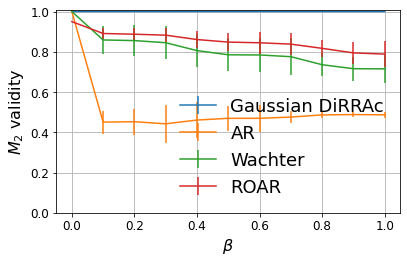

In [35]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_wachter, std_wachter, label='Wachter')
ax.errorbar(alpha_l, validity_roar, std_roar, label='ROAR')

ax.set(xlabel='$\\beta$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
plt.ylim(0, 1.01)
# ax.set_aspect('equal')
plt.savefig('result/figure3/both_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()